# 나의 첫 번째 캐글 경진대회, 무작정 따라해보기
-----
### 프로젝트 - This is your playground! Leaderboard를 정복해 주세요!

## 학습 목표
- 데이터 사이언스 관련 최대 커뮤니티인 캐글의 경진대회에 직접 참여해서 문제를 해결해본다.
캐글에서 데이터를 내려받는 것으로부터 시작해서, 로컬 서버에서 자유롭게 다루어보며 문제 해결을 위한 고민을 해본다.
- 앙상블 기법의 개념과 강점을 이해하고, 여러 모델의 예측 결과를 Averaging 한 최종 결과로 캐글에 제출해본다.
- 하이퍼 파라미터 튜닝의 필요성과 의미를 이해하고, Grid Search, Random Search 등의 기법을 알아본다.
- Grid Search 기법을 활용해서 직접 하이퍼 파라미터 튜닝 실험을 해보고, 모델의 성능을 최대한 끌어올려본다.

## 순서
> **Step1.** 참가 규칙과 데이터, 평가 기준 살펴보기<br>
**Step2.** 데이터 이해하기<br>
**Step3.** 모델설계<br>
**Step4.** 캐글에 첫 결과 제출하기<br>
**Step5.** 랭킹을 올리고 싶다면? 최적의 모델을 찾아서, 하이퍼 파라미터 튜닝

## 준비물
---
이번 노드에서는 회귀 모델을 구현하는 데에 사용하는 **`xgboost`**와 **`lightgbm`** 라이브러리와, 결측 데이터를 확인하는 **`missingno`** 라이브러리가 필요합니다. 터미널에서 다음 명령어로 **현재 사용하는 아나콘다 가상환경** (예: **`aiffel`**)에 설치해주세요.

**`$`** 표시를 제외한 명령어를 한 줄씩 실행하면 됩니다.
> $ conda install -c conda-forge xgboost

> $ conda install -c conda-forge lightgbm

> $ conda install -c conda-forge missingno

**`사이킷런 (scikit-learn)`** 버전을 **`0.23.0`**로 맞춰줄게요.

> $ pip install scikit-learn==0.23.0

### <span style="color:green">Step1. 참가 규칙, 평가 기준 살펴보기</span>
---
> 대회는 데이터 사이언티스트들을 위한 경진대회 사이트 **캐글(Kaggle)** 에서 진행됩니다.

캐글에는 아주 다양한 경진대회들이 있고, 각 경진대회들은 모두 대회 소개, 데이터셋 소개, 규칙 설명 등 대회에 참가하는 사람들을 위한 세부 내용들로 구성되어 있습니다.

홈페이지 링크를 통해 확인해 봅니다.
> https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

평가 기준은 **RMSE**입니다.

> - RMSE : **R**oot **M**ean **S**quared Error 의 약자
>- 수식 = **sqrt( 1/N * Σ((Yt - Ypr)^2) )** 이다.
>- 이는 실제 정답과 예측한 값의 차이의 제곱을 평균한 값의 제곱근이다.

데이터 파일
> 이 대회에서는 **train.csv**라는 모델 학습용 파일과, **test.csv**라는 테스트용 파일, 그리고 **sample_submission.csv**라는 제출용 파일이 제공됩니다.<br>
우리는 **train.csv**를 활용해서 데이터를 뜯어보고 모델을 학습시킨 후, **test.csv** 파일의 데이터에 대해 **price**를 예측해서 **sample_submission.csv**의 형식에 맞는 형태로 캐글에 제출을 해볼 것입니다.

**<div style="color:red">잠깐, 이번 대회에서는 데이터가 중간에 한 번 변경되었다고 합니다.</div>**
그래서 위에서 다운로드받은 데이터로 예측을 해서 그냥 제출하면 데이터의 길이가 맞지 않다는 에러가 나는데요, 이를 피하기 위해서 이번 실습 과정에서는 직접 다운을 받은 파일 대신 아래에 있는 파일을 활용해주시기 바랍니다.
> $ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/kaggle-kakr-housing-data.zip

> $ mv kaggle-kakr-housing-data.zip ~/aiffel/kaggle_kakr_housing

> $ cd ~/aiffel/kaggle_kakr_housing

> $ unzip kaggle-kakr-housing-data.zip

### <span style="color:green">Step2. 데이터 이해하기</span>
---
아래 사진에도 문제점이 몇가지 있었습니다.<br>예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지지 않고 나온다던가 하는 경우입니다. ㅠㅠ<br>그 외 다른 문제들이 눈에 띄시나요?<br>아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

추가로 직접 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다.

**✓ 필요한 라이브러리 import 하기**

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


**✓ Baseline 모델 다운로드 받고 데이터 경로 지정하기**

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'  # 옳바른 경로로 재설정

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/home/aiffel-dj49/aiffel/kaggle_kakr_housing/data/train.csv
/home/aiffel-dj49/aiffel/kaggle_kakr_housing/data/test.csv


Baseline 커널은 캐글의 서버에서 돌아가도록 코드가 설계되었기 때문에 데이터가  **../input** 이라는 디렉토리에 위치합니다.<br>경로명은 본인의 컴퓨터 디렉토리에 맞게 바꾸어 주세요.<br>리눅스 명령어 **`pwd`** 를 사용하면 손쉽게 파일의 절대경로를 찾을 수 있습니다.

**✓ 데이터 살펴보기**

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

Baseline 노트북은 먼저 위와 같이 데이터를 살펴보고 있네요.<br>각 변수들이 나타내는 의미를 읽어 보겠습니다.<br>집에 대한 다양한 정보가 들어있는 것으로 보입니다.<br>이들의 특징을 활용해서 집의 가격을 맞추어야 하겠죠.

**✓ 데이터 불러오기**

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)

# 데이터수와 컬럼수 출력
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


데이터를 **data, sub**이라는 변수로 불러옵니다.<br>학습 데이터는 **약 1만 5천 개**, 테스트 데이터는 **약 6천 개**로 이루어져 있군요.<br>테스트 데이터는 물론 우리가 맞추어야 할 집의 가격, **price**가 없기 때문에 컬럼이 하나 적습니다.

**Error]** **<span style="color:Orange">에러명</span>**: 사유

**✓ 학습 데이터에서 라벨 제거하기**

In [4]:
y = data['price']  # price 컬럼은 따로 y라는 변수에 저장
del data['price']  # 해당 컬럼은 삭제

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


**Tips]** 데이터 분석 과정에서 칼럼을 없애고 싶다면 **pandas.DataFrame.drop**도 사용할 수 있습니다.

**✓ 학습 데이터와 테스트 데이터 합치기**

In [5]:
train_len = len(data)  # training data의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용
data = pd.concat((data, sub), axis=0)  #  전체 데이터에 대해 탐색해보기 위해 두 데이터를 pd.concat으로 합쳐본다.

print(len(data))

21503


In [6]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


**✓ 간단한 전처리**

<AxesSubplot:>

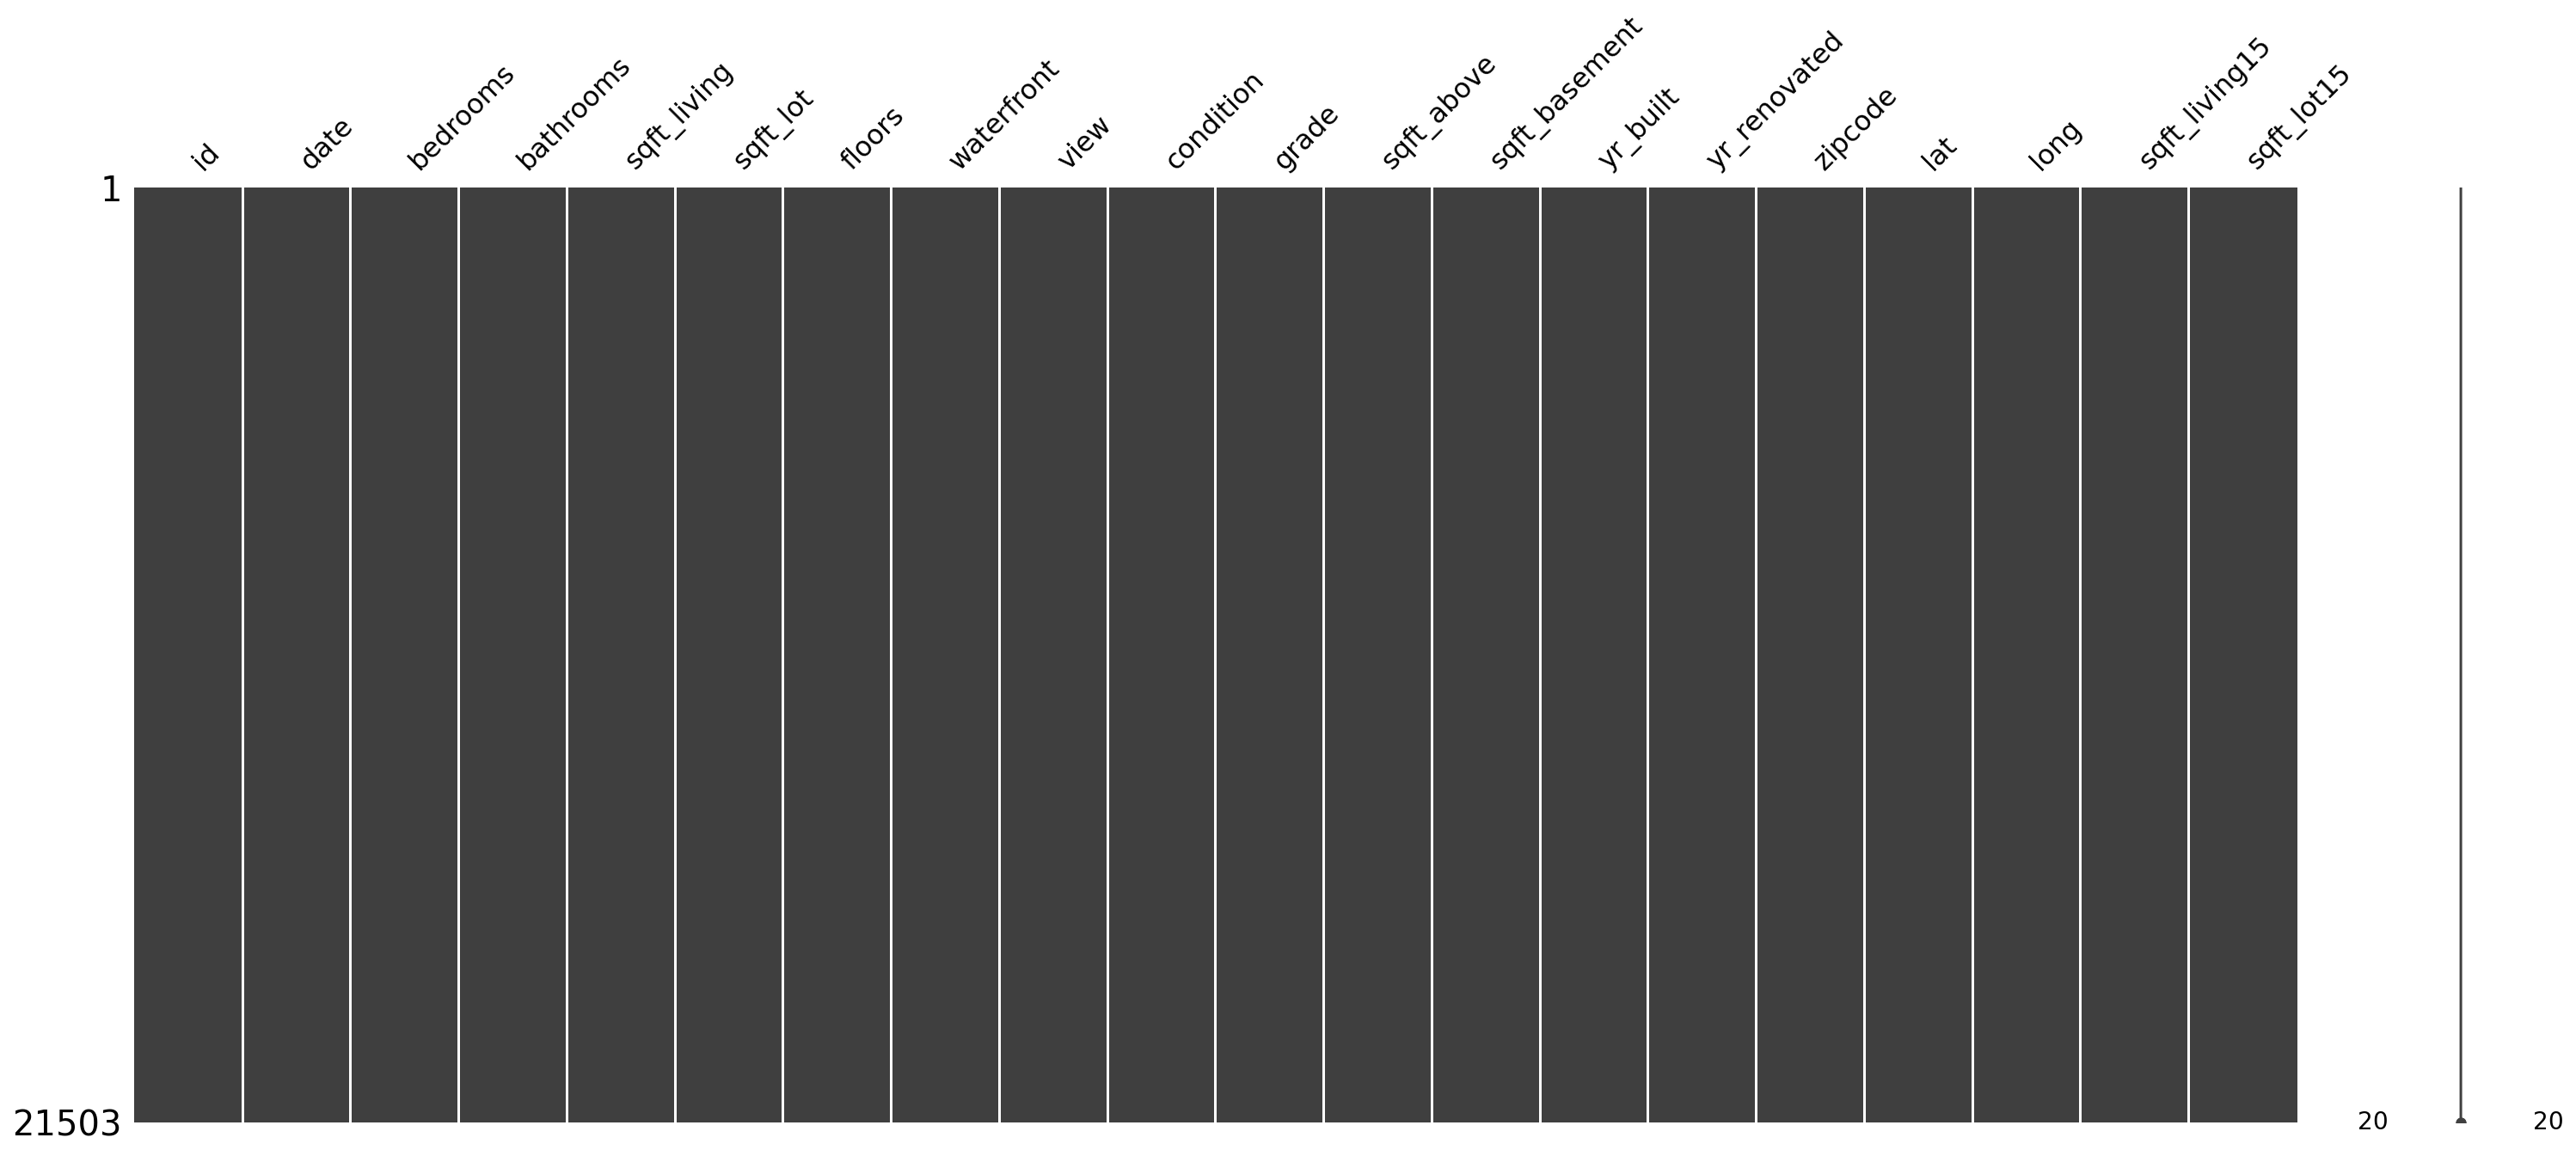

In [10]:
# missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있다.
msno.matrix(data)

만약 특정 row, col에 NaN이라는 **결측치가 있었다면 해당 부분이 하얗게** 나옵니다.<br>결측치가 없다면 매트릭스 전체가 까맣게 나올 겁니다.

**Tips]** 전체이미지가 안 보일 시 **`새 탭에서 이미지 열기`**를 눌러보세요!

In [11]:
# 직접 결측치의 개수를 출력해서 확인
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


**✓ id, date 변수 정리**

### <span style="color:green">Step3. 해결 방법을 제안해 보기</span>

# <span style="color:purple">루브릭 평가 기준</span>
---
번호|평가문항|상세기준
---|---|---
1 |캐글 데이터분석 전과정이 성공적으로 진행되었는가?|데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 진행되었다.
2 |전처리, 학습과정 및 결과에 대한 설명이 시각화를 포함하여 체계적으로 진행되었는가?|제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었다.
3 | 회귀모델 예측정확도가 기준 이상 높게 나왔는가?|다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었다.

# <span style="color:purple">회고</span>
---